<a href="https://colab.research.google.com/github/gasparfj/NeuronalNetwork_ParkinsonSeverity_Prediction/blob/main/PAC2_GFJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PAC 1: ACTIVIDAD

Gaspar Fuster Jimenez

Machine Learning

In [62]:
# Importar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

## 1. Leer el fichero de datos parkinsons_updrs.data



Primero cargamos el fichero que el enunciado nos proporciona y lo leemos con pandas, indicando que la separación es por comas.

In [63]:
from google.colab import files
uploaded = files.upload() # Importar el fichero del enundiado

Saving parkinsons_updrs.data to parkinsons_updrs (1).data


In [64]:
data = pd.read_csv('parkinsons_updrs.data', sep=',') # Leer el archivo

## 2. Realizar una estadística descriptiva univariante de las variables que incluya tablas y gráficos.

Primero con la función describe() obtendremos un resumen estadístico de todas las variables, excluyendo el ID del paciente. Transcribiremos la matriz resultante para tener las variables en las filas.

In [65]:
desc = data.iloc[:, 1:].describe().T

A continuación para tener una primera visualización de los datos, vamos a crear diferentes figuras. En primer lugar, crearemos un gráfico de barras para las variables categóricas, en este caso solo hay una, la variable sexo. Luego, iteraremos para el resto de variables y crearemos un histograma para cada una de ellas.

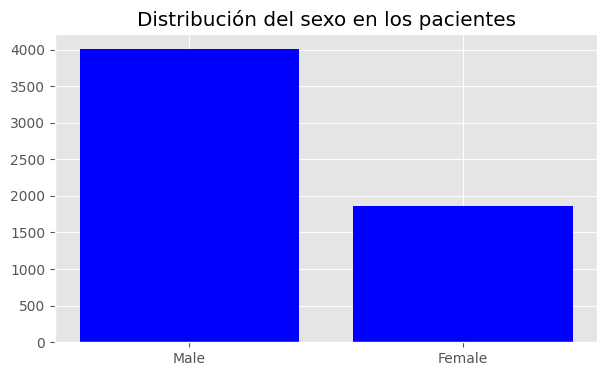

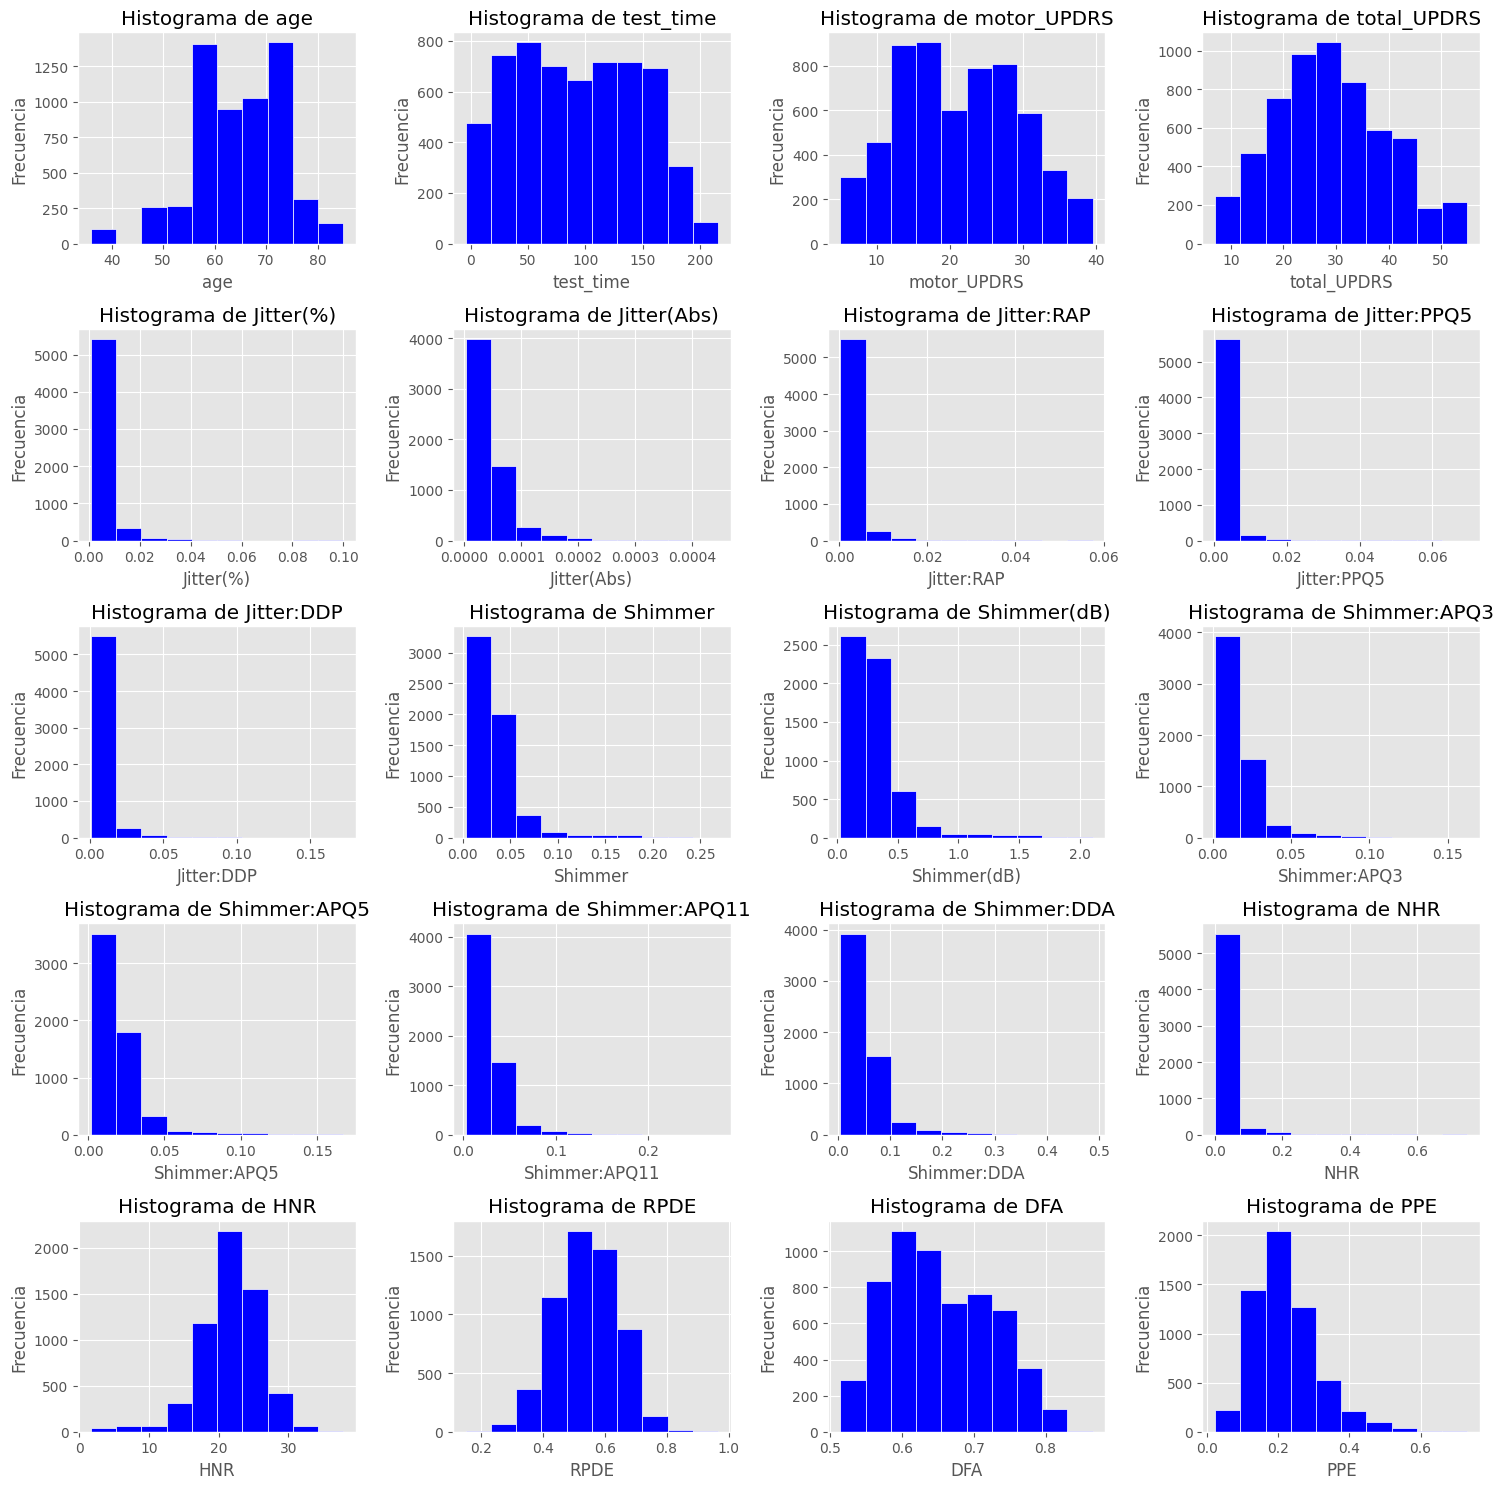

In [66]:
## Grafico de la unica variable cateórica (sexo)
conteo = data['sex'].value_counts() # Contar 0s y 1s
conteo = conteo.rename({0: 'Male', 1: 'Female'}) # Recodificar los valores
# Crear grafico de barras
plt.style.use('ggplot')
plt.figure(figsize=(7, 4))
plt.bar(conteo.index, conteo.values, color="blue")
plt.title("Distribución del sexo en los pacientes")

## Graficos de las variables continuas
# Excluyendo el id del paciente y el sexo hay 20 variables
# Creamos figura de 5 graficos por 4 graficos
fig, axes = plt.subplots(5, 4, figsize=(15, 15))
axes = axes.flatten()

# Hacer un histograma para cada variable
for i, col in enumerate(data.iloc[:, 1:].drop(data.columns[2], axis=1)):
    axes[i].hist(data[col], edgecolor="white", color="blue")
    axes[i].set_title(f"Histograma de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show() #Mostrar los graficos

Las variables Jitter y Shimmer (y derivados) tienen una distribución sesgada a la derecha. El resto de variables parece seguir una distribución normal.

## 3. Estandarizar mediante la transformación min-max las 16 variables que representan medidas biomédicas de la voz. Mostrar graficamente la transformación de las variables.

Antes de entrenar un algoritmo, es importante estandarizar los datos, ya que si una variable tiene una escala significativamente diferente al resto, esta puede influir de manera desproporcionada al modelo aunque esto no se corresponda con la realidad (Sierra, E. A. 2024).

Con el objetivo de mejorar el rendimiento del algoritmo, aplicaremos una estandarización de los datos min-max. Lo que transformará los datos a una escala de entre 0 (min) y 1 (max). Se utilizará la función MinMaxScaler() de la libreria sklearn.preprocessing.

In [67]:
voice_data = data.iloc[:, 6:] # Seleccionar datos para normalizar

scaler = MinMaxScaler() # Inicializar el escalador
voice_data_norm = scaler.fit_transform(voice_data) # Normalizar los datos

# Convertir a DataFrame
column_names = data.columns[6:]
voice_data_norm = pd.DataFrame(voice_data_norm, columns=column_names)

Ahora que tenemos estos datos estandarizados y almacenados en una variable, podemos visualizarlos con un mapa de calor con la función heatmap() de la libreria seaborn.

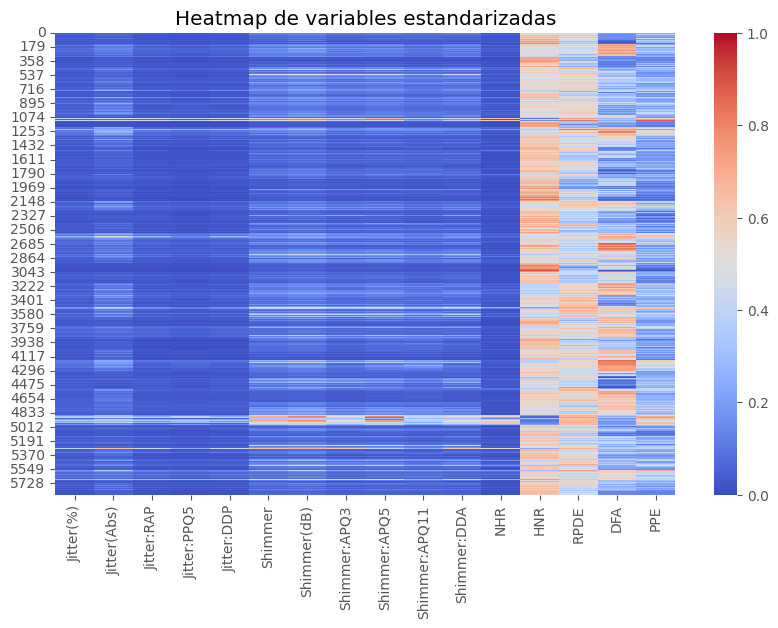

In [68]:
plt.figure(figsize=(10,6)) # Crear figura

sns.heatmap(voice_data_norm, cmap="coolwarm")  # Heatmap
plt.title("Heatmap de variables estandarizadas") # Titulo
plt.show()                                     # Dibujar figura

Observamos en esta figura el valor de cada variable en cada muestra, en una escala de color de azul (0) a rojo (1).

## 4. Crear la variable binaria de severidad del Parkinson. Mostrar en una tabla el numero de observaciones por severidad del Parkinson.

A continuación vamos a crear la variable que se quiere predecir (severidad). Esta, sera una variable binaria que se expresará como 1 si el valor de la variable "total_UPDRS" es mayor a 25 o 0 si es inferior.

Crearemos primero la lista de valores de esta variable con list comprehension y luego la convertiremos en data frame de pandas.

In [69]:
# Crear la variable severidad (1 si hay severidad, 0 si no)
severidad = [1 if i > 25 else 0 for i in data['total_UPDRS']]
severidad = pd.DataFrame(severidad, columns = ['severidad']) # Convertir a df

## 5. Separar los datos en training (67%) y test (33%).

En este punto, ya tenemos los datos con los que vamos a crear el moedelo. Tenemos, por una parte, las variables predictoras ya estandarizadas (voice_data_norm), y por otra parte, la variable a predecir (severidad).

Vamos a separarar estos datos aleatoriamente en entrenamiento y test.

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    voice_data_norm, severidad, test_size=0.33, random_state=123)

## 6. Implementar una red neuronal profunda densa para la predicción de la severidad con dos capas ocultas de 10 y 10 nodos cada una. Adicionalmente, implementar una segunda red neuronal profunda densa con tres capas ocultas de 10, 20 y 10 nodos cada una.

### Definir los modelos

Crearemos dos redes neuronales (modelo y modelo2).

Ambos modelos serán de tipo "Sequential (una pila de capas con un valor de entrada y salida); las capas ocultas utilizarán la función de activación "relu", ya que es la que se utiliza de forma estandar en las capas ocultas (Tech, R. 2022, Ali, M. 2025); en cambio, la función de activación de la capa de salida tendrá un nodo y la función de activación "sigmoid" que devuelve un valor entre 0 y 1, el cual representará la probabilidad de pertenecer a la clase 1 (severidad) o a la clase 0 (no severidad) (Tech, R. 2022, Ali, M. 2025).

Los dos modelos difieren en el numero de capas ocultas y numero de nodos: el modelo tendrá 2 capas ocultas de 10 nodos cada uno y el modelo2 tentrá tres capas ocultas con 10, 20 y 10 nodos.

Estos modelos se crean con la libreria tensorflow.

In [71]:
modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10, activation='relu', input_shape=[16]),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

modelo2 = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10, activation='relu', input_shape=[16]),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compilar modelos

Aquí se optimizan los modelos. En los dos modelos se aplicará la metrica accuracy y se aplicará la función de perdida "Binary-CrossEntropy" (útil para variables binarias) (Calvo, D. 2018).

In [72]:
modelo.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

modelo2.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']
)

### Entrenar modelos

Finalmente entrenamos el modelo con nuestros datos de entrenamiento. Utilizaremos en los dos modelos 250 épocas y una batch size de 16 (estándar).

Para afinar el modelo se puede jugar con estos dos argumentos pero el objetivo de esta práctica no es afinar un mejor modelo sinó comparar dos modelos con diferentes capas ocultas.

In [73]:
print('Entrenando...')
modelo.fit(
    X_train, y_train, epochs=250, batch_size=16,
    validation_data=(X_test, y_test), verbose=0
)
modelo2.fit(
    X_train, y_train, epochs=250, batch_size=16,
    validation_data=(X_test, y_test), verbose=0
)
print('Modelos entrenados')

Entrenando...
Modelos entrenados


## Comparar el rendimiento de las dos redes neuronales en el conjunto test.

### Evaluar modelo

Primero vamos a obtener la pérdida de los modelos y su accuracy (proporción de acierto del modelo).

In [82]:
loss, accuracy = modelo.evaluate(X_test, y_test)
print(f"Pérdida modelo 1: {loss:.4f}")
print(f"Accuracy modelo 1: {accuracy:.4f}")

loss2, accuracy2 = modelo2.evaluate(X_test, y_test)
print(f"Pérdida modelo 2: {loss2:.4f}")
print(f"Accuracy modelo 2: {accuracy2:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7058 - loss: 0.5517
Pérdida modelo 1: 0.5391
Accuracy modelo 1: 0.7210
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7391 - loss: 0.5549
Pérdida modelo 2: 0.5459
Accuracy modelo 2: 0.7375


### Predicciones

Realizamos predicciones para obtener otras métricas.

In [75]:
y_pred = modelo.predict(X_test)
y_pred2 = modelo2.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### Curva ROC y área bajo la curva (AUC)

Ahora dibujamos la curva ROC y calculamos el área bajo esta curva (AUC).

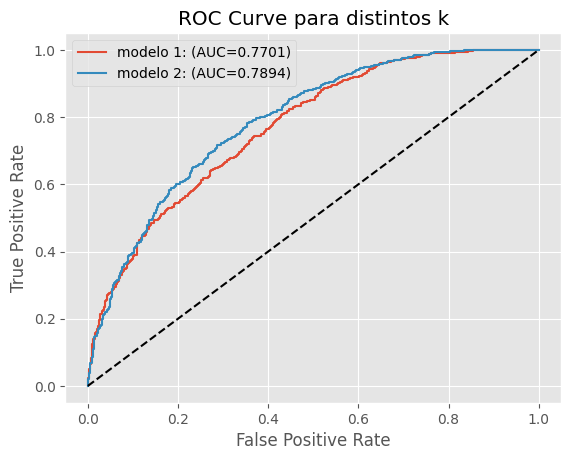

In [76]:
fpr, tpr, tresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr) # Calcular el area bajo la curva

fpr2, tpr2, tresholds2 = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2) # Calcular el area bajo la curva


plt.plot(fpr, tpr, label=f"modelo 1: (AUC={roc_auc:.4f})")
plt.plot(fpr2, tpr2, label=f"modelo 2: (AUC={roc_auc2:.4f})")
plt.plot([0,1],[0,1],'k--')  # Linea diagonal
plt.xlabel("False Positive Rate") # Titulo eje x
plt.ylabel("True Positive Rate") # Titulo eje y
plt.title("ROC Curve para distintos k") # Titulo del grafico
plt.legend() # Incluir leyenda
plt.show() # Mostrar el grafico

### Matriz de confusión

Para obtener la matriz de confusión debemos convertir las predicciones de los modelos a sus clases. Para ello, vamos a considerar que si el valor es superior a 0.5 pertenece a la clase 1 y si es inferior pertenece a la clase 0.

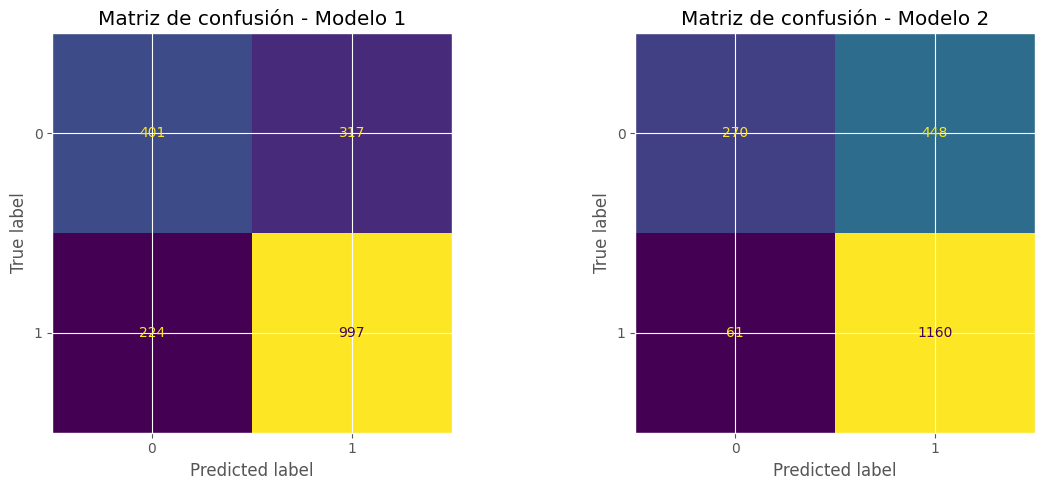

In [80]:
# Convertir las predicciones a clases
y_pred_classes = (y_pred > 0.5).astype(int)
y_pred2_classes = (y_pred2 > 0.5).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Dibujar matriz de confusion del modelo 1
cm = confusion_matrix(y_test, y_pred_classes)
cm_1 = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_1.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Matriz de confusión - Modelo 1")

# Dibujar matriz de confusion del modelo 2
cm2 = confusion_matrix(y_test, y_pred2_classes)
cm_2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
cm_2.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Matriz de confusión - Modelo 2")

plt.tight_layout()
plt.show()

También podemos obtener los valores de sensibilidad y especificidad con la función recall_score()

In [81]:
## Sensibilidad y especificidad modelo 1
# Sensibilidad (Recall para la clase positiva)
sensibilidad = recall_score(y_test, y_pred_classes, pos_label=1)
# Especificidad (Recall de la clase negativa)
especificidad = recall_score(y_test, y_pred_classes, pos_label=0)

## Sensibilidad y especificidad modelo 2
# Sensibilidad (Recall para la clase positiva)
sensibilidad2 = recall_score(y_test, y_pred2_classes, pos_label=1)
# Especificidad (Recall de la clase negativa)
especificidad2 = recall_score(y_test, y_pred2_classes, pos_label=0)

print(f"Sensibilidad modelo 1: {sensibilidad:.4f}")
print(f"Especificidad modelo 1: {especificidad:.4f}")
print()
print(f"Sensibilidad modelo 2: {sensibilidad2:.4f}")
print(f"Especificidad modelo 2: {especificidad2:.4f}")

Sensibilidad modelo 1: 0.8165
Especificidad modelo 1: 0.5585

Sensibilidad modelo 2: 0.9500
Especificidad modelo 2: 0.3760


### Discusión

El modelo con tres capas ocultas de 10, 20 y 10 nodos (modelo 2) resulta ser muy ligeramente superior al modelo con dos capas ocultas de 10 nodos (modelo 1).

Así como se puede ver en la tabla resumen de abajo, aunque el modelo 2 tiene una Loss (perdida) ligeramente mayor, tiene una accuracy superior por lo que el porcentaje de aciertos es mayor en el modelo 2; asimismo, el área bajo la curva ROC (AUC) es también superior en este modelo, por lo que separa las clases mejor que el modelo 1; finalmente, aunque el porcentaje de aciertos (accuracy) es mejor en el modelo 2, un modelo es mejor identificando positivos y otro identificando negativos: el modelo 1 tiene una sensitividad mejor que el 2 (detecta más casos severos) y el modelo 2 tiene una especificidad mayor (detecta mejor los casos no severos).

En casos clínicos como este, aunque el modelo 2 parece ser superior en todos los aspectos, puede ser mejore escoger el modelo con más sensitividad, ya que es más grave no detectar un caso grave que no detectar un caso no grave.

|  | Loss | Accuracy | AUC | Sensitividad | Especificidad |
| :---: | :---: | :---: | :---: | :---: | :---: |
| **Modelo 1** | 0.5391 | 0.7210 | 0.7701 | 0.8165 | 0.5585 |
| **Modelo 2** | 0.5459 | 0.7375 | 0.7894 | 0.9500 | 0.3760 |

**Tabla 1: Resumen de las métricas de calidad de los dos modelos.**

## Reflexión final, ¿crees que este conjunto de datos tiene alguna limitación como muestra representativa de la población de personas con Parkinson?

Este conjunto de datos no es representativo de la población de personas con Parkinson ya que hay una proporción desigual de mediciones en sujetos masculinos y en sujetos femeninos. Mas del doble de mediciones se han hecho en hombres (4008 vs. 1867) por lo que en este modelo posiblemente existe un sesgo que perjudica al sexo femenino, siendo muy probable que el modelo prediga mejor la severidad en pacientes masculinos.

Mediciones en el sexo masculino y femenino:
sex
Male      4008
Female    1867
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribución del sexo en los pacientes')

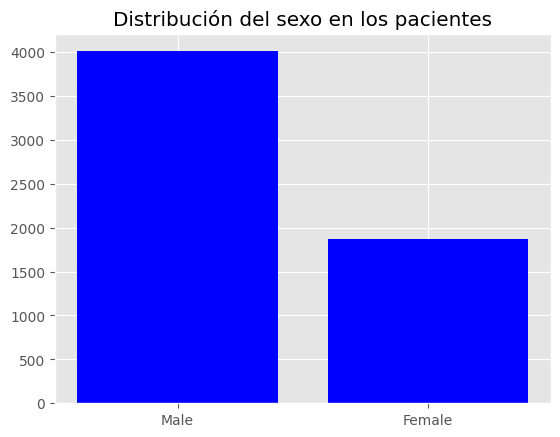

In [85]:
print("Mediciones en el sexo masculino y femenino:")
print(conteo)
plt.bar(conteo.index, conteo.values, color="blue")
plt.title("Distribución del sexo en los pacientes")

## Bibliografia

Ali, M. (2025). Introduction to Activation Functions in Neural Networks. Retrieved from https://www.datacamp.com/tutorial/introduction-to-activation-functions-in-neural-networks

Calvo, D. (2018). Función de coste - Redes neuronales. Retrieved from https://www.diegocalvo.es/funcion-de-coste-redes-neuronales/

K, B. (2022). Introducción a las redes neuronales profundas. Retrieved from https://www.datacamp.com/es/tutorial/introduction-to-deep-neural-networks

Sierra, E. A. (2024). Tutorial: Como normalizar datos con python. Retrieved from https://medium.com/@noyomedicen/como-normalizar-datos-con-python-4a967f3a04f8

Tech, R. (2021). Tu primera red neuronal en Python y Tensorflow. Retrieved from https://www.youtube.com/watch?v=iX_on3VxZzk

Tech, R. (2022). Funciones de activación a detalle (Redes neuronales). Retrieved from https://www.youtube.com/watch?v=_0wdproot34